In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as spr
import gurobipy as grb
from math import factorial
import itertools
import operator

data_X = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Xvals.csv")
data_Y = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/Yvals.csv")
data_affmat = pd.read_csv("https://github.com/math-econ-code/mec_optim_2021-01/raw/master/data_mec_optim/marriage_personality-traits/affinitymatrix.csv")

In [2]:
class random_panel:
    def __init__(self, init_matrix, time, speed=1):
        self.time = time
        self.init_matrix = init_matrix
        self.speed = speed
    def generate(self):
        X_panel = np.empty((self.time, self.init_matrix.shape[0], self.init_matrix.shape[1]))
        X_panel[0, :, :] = self.init_matrix
        for i in range(self.time - 1):
            X_panel[i+1, :, :] = X_panel[i, :, :] + self.speed * np.random.randn(self.init_matrix.shape[0], self.init_matrix.shape[1])
        return X_panel

In [3]:
np.random.seed(42)
n = 10
t = 10
speed = 1

sdX = data_X.std().to_numpy()
sdY = data_Y.std().to_numpy()
mX = data_X.mean().to_numpy()
mY = data_Y.mean().to_numpy()

affmat = data_affmat.to_numpy()[0: 10, 1:]
Xvals = ((data_X-mX)/sdX).to_numpy()[0:n, :]
Yvals = ((data_Y-mY)/sdY).to_numpy()[0:n, :]


Xvals_dyna = random_panel(Xvals, t, speed).generate()
Yvals_dyna = random_panel(Yvals.T, t, speed).generate()
phi_dyna = Xvals_dyna @ affmat @ Yvals_dyna

In [4]:
class dynamic_matching_nocost:
    def __init__(self, phi):
        self.phi = phi
        self.n = phi.shape[1]
        self.t = phi.shape[0]
        self.vecphi = self.phi.flatten()
        
    def optimize(self):
        p = np.ones((self.t, self.n, 1))/self.n
        q = np.ones((self.t, self.n, 1))/self.n
        d = np.concatenate((p,q), axis = None)

        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))

        A = spr.kron(spr.identity(self.n*self.t), sparse_one)
        B = spr.kron(spr.kron(spr.identity(self.t), sparse_one), spr.identity(self.n))

        Aconstr = spr.vstack([A, B])

        m=grb.Model('Dynamic Optimal Matching')
        x = m.addMVar(shape=self.t * self.n**2, name="x")
        m.setObjective(self.vecphi @ x, grb.GRB.MAXIMIZE)
        m.setParam('OutputFlag', False)
        m.addConstr(Aconstr @ x == d, name="Constr")
        m.optimize()

        if m.status == grb.GRB.Status.OPTIMAL:
            self.pi_panel = np.array(m.getAttr('x')).reshape(self.t, self.n, self.n)
            self.pi_surplus = self.vecphi @ m.getAttr('x')
            
    def surplus(self):
        print('The total surplus generated is: ', self.pi_surplus)
    
    def coupling(self):
        print(self.pi_panel)
    
    def matching_of_man(self, man):
        for time in range(self.t):
            if np.all(self.pi_panel[time, man - 1, :] == 0):
                print('Period', time+1, ': Single')
            else:
                print('Period', time+1, ': Woman', np.argwhere(self.pi_panel[time, man-1,:] != 0)[0][0] + 1)
        
    def matching_graph(self):
        plt.rcParams["figure.figsize"] = (20, 6)
        matchings = np.empty((self.t, self.n))
        for time in range(self.t):
            matchings[time, :] = np.argwhere(self.pi_panel[time, : ,:] != 0)[:, 1] + 1
        plt.plot(matchings)
        plt.show()

In [5]:
test = dynamic_matching_nocost(phi_dyna)

Academic license - for non-commercial use only - expires 2021-07-30
Using license file c:\gurobi911\gurobi.lic
The total surplus generated is:  57.02919653858992


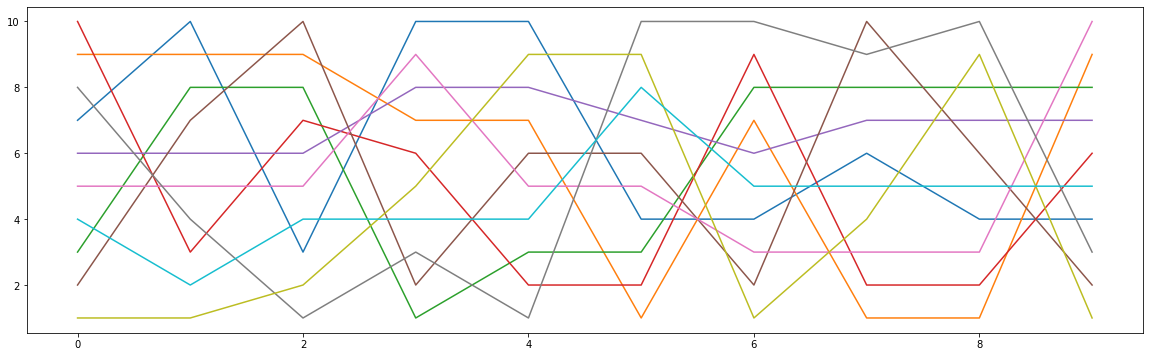

In [6]:
test.optimize()
test.surplus()
test.matching_graph()

In [7]:
class dynamic_matching_no_information:
    def __init__(self, phi, cost, cost_type):
        self.phi = phi
        self.C = cost
        self.n = phi.shape[1]
        self.t = phi.shape[0]
        self.vecphi = self.phi.flatten()
        self.cost_type = cost_type
    def optimize(self):
        phi_t = self.phi[0, :, :]
        vecphi_t = phi_t.flatten()
        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))
        p_t = np.ones((self.n, 1))/self.n
        q_t = np.ones((self.n, 1))/self.n
        d_t = np.concatenate((p_t, q_t), axis=None)

        A_loop = spr.kron(sparse_one, spr.identity(self.n))
        B_loop = spr.kron(spr.identity(self.n), sparse_one)
        Aconstr_loop = spr.vstack([A_loop, B_loop])

        self.pi_panel_loop = np.empty((self.t, self.n, self.n))
        self.optimal_values_loop = []

        for iteration in range(self.t):
            p = grb.Model('Optimal Coupling with reassignment cost')
            x = p.addMVar(shape = self.n**2, name = 'x')
            p.setObjective(vecphi_t @ x, grb.GRB.MAXIMIZE)
            p.addConstr(Aconstr_loop @ x == d_t)
            p.setParam('OutputFlag', False)
            p.optimize()
            if p.status == grb.GRB.Status.OPTIMAL:
                self.optimal_values_loop.append((self.phi[iteration, :, :]).flatten() @ p.getAttr('x'))
                matpi_t = np.array(p.getAttr('x')).reshape(self.n, self.n)
                self.pi_panel_loop[iteration, :, :] = matpi_t
            if iteration < self.t - 1 and (self.cost_type == 'Fixed' or self.cost_type == 'fixed'):
                vecphi_t = (self.phi[iteration + 1, :, :] + (self.C * matpi_t)).flatten()
            elif iteration < self.t - 1 and (self.cost_type == 'Variable' or self.cost_type == 'variable'):
                vecphi_t = (self.phi[iteration + 1, :, :] + (self.C * matpi_t * self.phi[iteration, :, :])).flatten()

        self.pi_loop_surplus = np.sum(self.optimal_values_loop)
        
    def surplus(self):
        print('With', self.cost_type, 'reassignment cost ', self.C ,', the surplus generated is', self.pi_loop_surplus)
        
    def surplus_loss(self):
        p = np.ones((self.t, self.n, 1))/self.n
        q = np.ones((self.t, self.n, 1))/self.n
        d = np.concatenate((p,q), axis = None)

        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))

        A = spr.kron(spr.identity(self.n*self.t), sparse_one)
        B = spr.kron(spr.kron(spr.identity(self.t), sparse_one), spr.identity(self.n))

        Aconstr = spr.vstack([A, B])

        m=grb.Model('Optimal Marriage')
        x = m.addMVar(shape=self.t * self.n**2, name="x")
        m.setObjective(self.vecphi @ x, grb.GRB.MAXIMIZE)
        m.setParam('OutputFlag', False)
        m.addConstr(Aconstr @ x == d, name="Constr")
        m.optimize()

        if m.status == grb.GRB.Status.OPTIMAL:
            pi_surplus = self.vecphi @ m.getAttr('x')
        self.surplus_loss_l = pi_surplus - self.pi_loop_surplus
        print('The surplus loss is of ', (self.surplus_loss_l/pi_surplus)*100, '% due to the reassignment cost')
        
    def matching_of_man(self, man):
        for time in range(self.t):
            if np.all(self.pi_panel_loop[time, man - 1, :] == 0):
                print('Period', time+1, ': Single')
            else:
                print('Period', time+1, ': Woman', np.argwhere(self.pi_panel_loop[time, man-1,:] != 0)[0][0] + 1)
        
    def matching_graph(self):
        plt.rcParams["figure.figsize"] = (20, 6)
        self.matchings = np.empty((self.t, self.n))
        for time in range(self.t):
            self.matchings[time, :] = np.argwhere(self.pi_panel_loop[time, : ,:] != 0)[:, 1] + 1
        plt.plot(self.matchings)
        plt.show()

With fixed reassignment cost  5 , the surplus generated is 56.659456841418255
The surplus loss is of  0.6483340457400193 % due to the reassignment cost


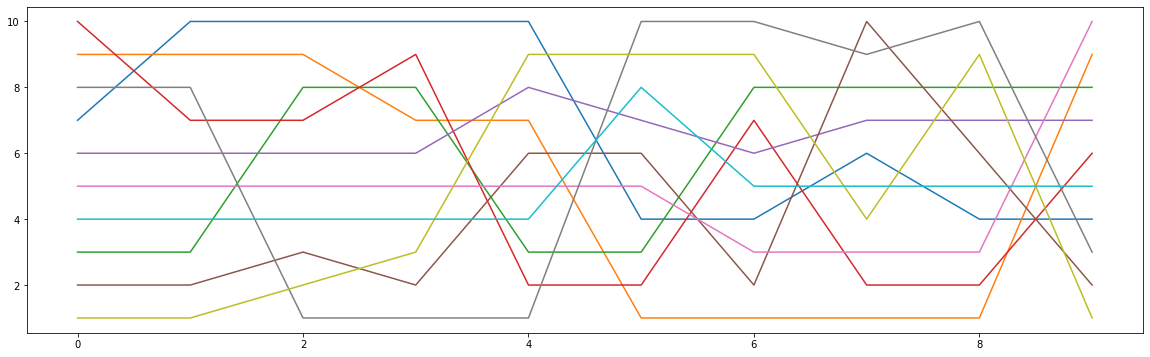

In [8]:
test_no_inf_fixed = dynamic_matching_no_information(phi_dyna, 5, cost_type='fixed')

test_no_inf_fixed.optimize()
test_no_inf_fixed.surplus()
test_no_inf_fixed.surplus_loss()
test_no_inf_fixed.matching_graph()

With variable reassignment cost  20 , the surplus generated is 43.06823385535635
The surplus loss is of  24.480377649694955 % due to the reassignment cost


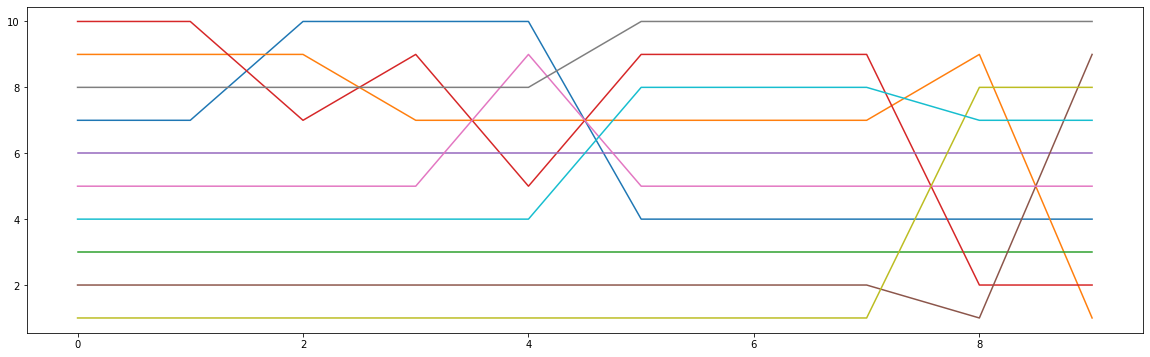

In [9]:
test_no_inf_var = dynamic_matching_no_information(phi_dyna, 20, cost_type='variable')

test_no_inf_var.optimize()
test_no_inf_var.surplus()
test_no_inf_var.surplus_loss()
test_no_inf_var.matching_graph()

In [10]:
class dynamic_matching_full_information:
    def __init__(self, phi, cost):
        self.phi = phi
        self.cost = cost
        self.n = phi.shape[1]
        self.t = phi.shape[0]
        if self.n > 5:
            print('WARNING: n is too high, consider using a smaller population')
    def optimize(self):
        self.couplings = 1/self.n * np.array(list(itertools.permutations(np.identity(self.n))))
        
        self.nodes = np.linspace(0, factorial(self.n)*self.t, (factorial(self.n)*self.t) + 1)
        n_nodes = (factorial(self.n)*self.t)+1
        grid_start = np.empty((factorial(self.n) + (factorial(self.n)**2)*(self.t - 1), 1))
        for node in range(n_nodes - factorial(self.n)):
            grid_start[node*factorial(self.n):(node+1)*factorial(self.n)] = node*np.ones(factorial(self.n)).reshape(factorial(self.n), 1)


        edges_finish_array = np.empty((factorial(self.n) + (factorial(self.n)**2)*(self.t - 1), 1))
        edges_finish_array[0:factorial(self.n)] = np.linspace(1, factorial(self.n), factorial(self.n)).reshape(factorial(self.n), 1)
        temp_finish_edges = np.empty((factorial(self.n)*(self.t - 1), factorial(self.n)))

        for reassignment_finish in range(self.t - 1):
            for i_finish in range(factorial(self.n)):
                temp_finish_edges[i_finish + reassignment_finish*factorial(self.n), :] = np.linspace(factorial(self.n)*(reassignment_finish+1)+1, factorial(self.n)*(reassignment_finish+2), factorial(self.n))
        temp_finish_edges_n = temp_finish_edges.reshape(factorial(self.n)**2*(self.t - 1), order='C')
        edges_finish_array[factorial(self.n):] = temp_finish_edges_n.reshape(factorial(self.n)**2*(self.t - 1), 1)

        self.edges = np.concatenate((grid_start, edges_finish_array), axis=1)
        

        init_assignment_payoff = []
        for j in range(factorial(self.n)):
            assignment_payoff = np.trace(self.couplings[j, :, :].T @ self.phi[0, :, :])
            init_assignment_payoff.append(assignment_payoff)

        network_assignment_payoff = []
        for k in range(self.t - 1):
            for m in range(factorial(self.n)):
                for l in range(factorial(self.n)):
                    assignment_payoff_alt = np.trace(self.couplings[l, :, :].T @ ((self.phi[k + 1, :, :] + self.cost*self.couplings[m, :, :])))
                    network_assignment_payoff.append(assignment_payoff_alt)

        self.payoffs = np.concatenate((init_assignment_payoff, network_assignment_payoff), axis=0).reshape(self.edges.shape[0], 1)
        self.pre_dict = np.concatenate((self.edges, self.payoffs), axis=1)
        self.edges_dict = {(key1, key2): value for key1, key2, value in self.pre_dict}
        
        
        self.best_path_payoffs = {v: float('-inf') for v in self.nodes}
        self.best_path_payoffs[0] = 0

        self.best_paths = {v: [] for v in self.nodes}
        self.best_paths[0] = [0]

        for _ in range(len(self.nodes) - 1):
            for (u, v), w_uv in self.edges_dict.items():
                if self.best_path_payoffs[u] + w_uv > self.best_path_payoffs[v]:
                    self.best_path_payoffs[v] = self.best_path_payoffs[u] + w_uv
                    self.best_paths[v] = self.best_paths[u] + [v]     
                    
        self.final_nodes_dict = {key: value for key, value in self.best_path_payoffs.items() if key > self.nodes[-1] - factorial(self.n)}
        
        
        
        self.best_final_node = max(self.final_nodes_dict.items(), key=operator.itemgetter(1))[0]
        self.optimal_path = self.best_paths[self.best_final_node]
        self.coupling_index = []
        self.pi_panel = []
        for node in self.optimal_path[1:]:
            self.coupling_index.append(node - (self.optimal_path.index(node) - 1)*factorial(self.n))
        for index in self.coupling_index:
            self.pi_panel.append(self.couplings[int(index - 1), :, :].flatten())
        self.optimal_matchings = np.array(self.pi_panel).reshape(self.t, self.n, self.n)
        
        optimal_values = []
        for assignment in range(self.t):
            surplus_value = np.trace(self.optimal_matchings[assignment, :, :].T @ self.phi[assignment, :, :])
            optimal_values.append(surplus_value)
        self.surplus_final = np.array(optimal_values).sum()
        
    def surplus(self):
        print(self.surplus_final)
        
    def matching_graph(self):
        plt.rcParams["figure.figsize"] = (20, 6)
        self.matchings = np.empty((self.t, self.n))
        for time in range(self.t):
            self.matchings[time, :] = np.argwhere(self.optimal_matchings[time, : ,:] != 0)[:, 1] + 1
        plt.plot(self.matchings)
        plt.show()
        
    def value_of_information(self):
        phi_t = self.phi[0, :, :]
        vecphi_t = phi_t.flatten()
        sparse_one = spr.csr_matrix(np.ones(self.n).reshape(1, self.n))
        p_t = np.ones((self.n, 1))/self.n
        q_t = np.ones((self.n, 1))/self.n
        d_t = np.concatenate((p_t, q_t), axis=None)

        A_loop = spr.kron(sparse_one, spr.identity(self.n))
        B_loop = spr.kron(spr.identity(self.n), sparse_one)
        Aconstr_loop = spr.vstack([A_loop, B_loop])

        self.pi_panel_loop = np.empty((self.t, self.n, self.n))
        self.optimal_values_loop = []

        for iteration in range(self.t):
            p = grb.Model('Optimal Coupling with reassignment cost')
            x = p.addMVar(shape = self.n**2, name = 'x')
            p.setObjective(vecphi_t @ x, grb.GRB.MAXIMIZE)
            p.addConstr(Aconstr_loop @ x == d_t)
            p.setParam('OutputFlag', False)
            p.optimize()
            if p.status == grb.GRB.Status.OPTIMAL:
                self.optimal_values_loop.append((self.phi[iteration, :, :]).flatten() @ p.getAttr('x'))
                matpi_t = np.array(p.getAttr('x')).reshape(self.n, self.n)
                self.pi_panel_loop[iteration, :, :] = matpi_t
            if iteration < (self.t - 1):
                vecphi_t = (self.phi[iteration + 1, :, :] + (self.cost * matpi_t)).flatten()

        pi_loop_surplus = np.sum(self.optimal_values_loop)
        self.value_info = self.surplus_final - pi_loop_surplus
        return self.value_info

In [11]:
np.random.seed(42)
n_dp = 4
t_dp = 20
speed = 1

sdX_dp = data_X.std().to_numpy()
sdY_dp = data_Y.std().to_numpy()
mX_dp = data_X.mean().to_numpy()
mY_dp = data_Y.mean().to_numpy()

affmat_dp = data_affmat.to_numpy()[0: 10, 1:]
Xvals_dp = ((data_X - mX_dp)/sdX_dp).to_numpy()[0:n_dp, :]
Yvals_dp = ((data_Y - mY_dp)/sdY_dp).to_numpy()[0:n_dp, :]


Xvals_dyna_dp = random_panel(Xvals_dp, t_dp, speed).generate()
Yvals_dyna_dp = random_panel(Yvals_dp.T, t_dp, speed).generate()

phi_dyna_dp = Xvals_dyna_dp @ affmat_dp @ Yvals_dyna_dp

In [12]:
test_dp = dynamic_matching_full_information(phi_dyna_dp, 30)
test_dp.optimize()
test_dp.surplus()

87.71100885814371


In [13]:
test_dp.value_of_information()

3.24024736983597

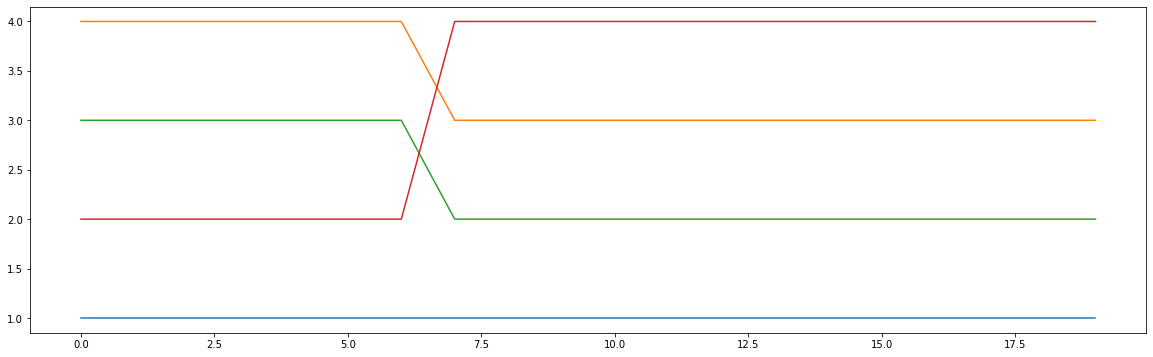

In [15]:
test_dp.matching_graph()

Text(0, 0.5, 'Value of information')

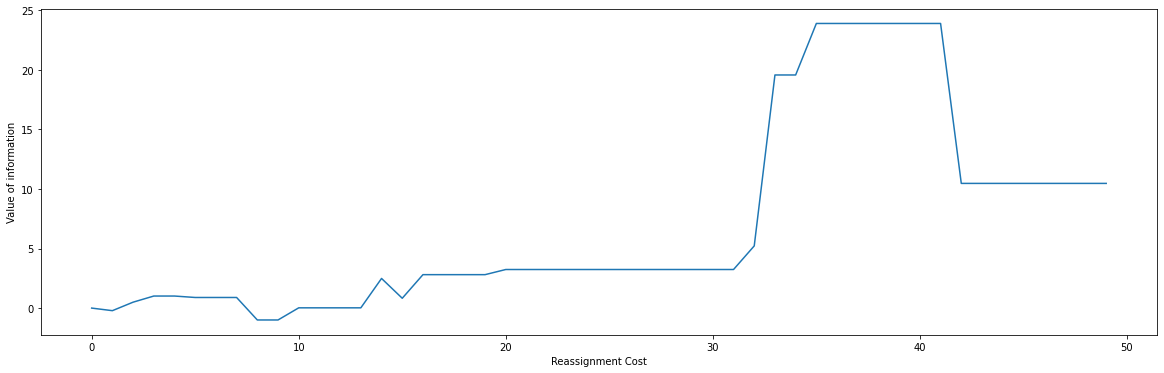

In [19]:
info_values = []
for i in range(50):
    test_dp_graph = dynamic_matching_full_information(phi_dyna_dp, i)
    test_dp_graph.optimize()
    info_values.append(test_dp_graph.value_of_information())
plt.plot(info_values)
plt.xlabel('Reassignment Cost')
plt.ylabel('Value of information')

In [20]:
np.random.seed(42)
n_comparison = 4
t_comparison = 20
speed = 1

sdX_comparison = data_X.std().to_numpy()
sdY_comparison = data_Y.std().to_numpy()
mX_comparison = data_X.mean().to_numpy()
mY_comparison = data_Y.mean().to_numpy()

affmat_comparison = data_affmat.to_numpy()[0: 10, 1:]
Xvals_comparison = ((data_X - mX_comparison)/sdX_comparison).to_numpy()[0:n_comparison, :]
Yvals_comparison = ((data_Y - mY_comparison)/sdY_comparison).to_numpy()[0:n_comparison, :]


Xvals_dyna_comparison = random_panel(Xvals_comparison, t_comparison, speed).generate()
Yvals_dyna_comparison = random_panel(Yvals_comparison.T, t_comparison, speed).generate()

phi_dyna_comparison = Xvals_dyna_comparison @ affmat_comparison @ Yvals_dyna_comparison

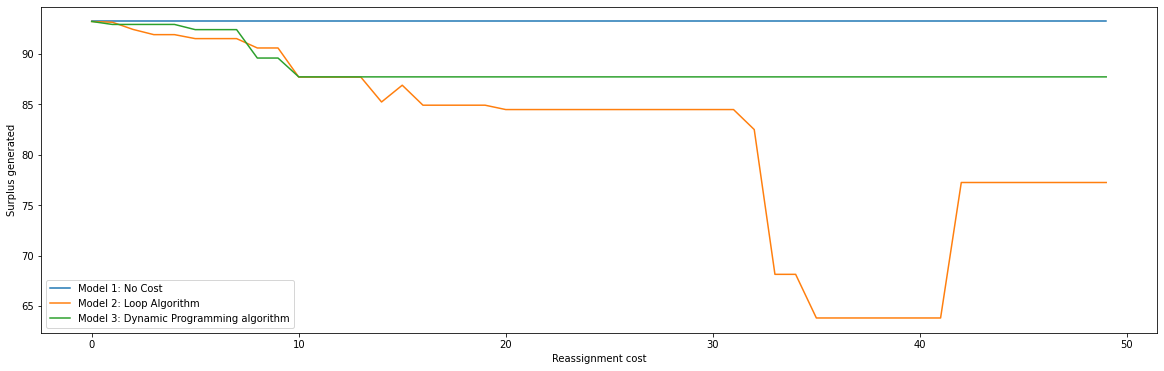

In [21]:
model_1_surplus = []
model_2_surplus = []
model_3_surplus = []

for j in range(50):
    model_1 = dynamic_matching_nocost(phi_dyna_comparison)
    model_1.optimize()
    model_1_surplus.append(model_1.pi_surplus)
    
    model_2 = dynamic_matching_no_information(phi_dyna_comparison, j, 'fixed')
    model_2.optimize()
    model_2_surplus.append(model_2.pi_loop_surplus)
    
    model_3 = dynamic_matching_full_information(phi_dyna_comparison, j)
    model_3.optimize()
    model_3_surplus.append(model_3.surplus_final)
    
plt.plot(model_1_surplus, label='Model 1: No Cost')
plt.plot(model_2_surplus, label='Model 2: Loop Algorithm')
plt.plot(model_3_surplus, label='Model 3: Dynamic Programming algorithm')
plt.legend()
plt.xlabel("Reassignment cost")
plt.ylabel("Surplus generated")

plt.show()